# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from math import log
from math import floor

from scipy.signal import find_peaks
from scipy.signal import peak_widths

from scipy.integrate import simpson

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score

from sklearn.metrics.cluster import v_measure_score

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 80)

In [3]:
path_to_save_data = './../data/processed_data'
path_to_save = './../results/spectral_features_clustering/'

# Loading data

## Train & Test data (*smoothed & scaled*)

In [4]:
path_to_ftir_data = './../data/preprocessed_data/ftir_scaled.csv'

In [5]:
data = pd.read_csv(path_to_ftir_data, index_col=0)

print(data.shape)
data.head(3)

(30, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,1876.657440,1875.693070,1874.728700,1873.764340,1872.799970,1871.835600,1870.871240,1869.906870,1868.942500,1867.978140,1867.013770,1866.049400,1865.085040,1864.120670,1863.156300,...,838.034590,837.070220,836.105860,835.141490,834.177120,833.212760,832.248390,831.284020,830.319660,829.355290,828.390920,827.426560,826.462190,825.497820,824.533460,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,0.009606,0.010241,0.010927,0.011667,0.012465,0.013324,0.014248,0.015257,0.016362,0.017554,0.018820,0.020172,0.021624,0.023174,0.024816,...,0.065789,0.063890,0.061982,0.060076,0.058172,0.056248,0.054288,0.052317,0.050374,0.048435,0.046505,0.044587,0.042687,0.040807,0.038950,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,0.000529,0.000660,0.000808,0.000976,0.001165,0.001374,0.001606,0.001952,0.002322,0.002637,0.002887,0.003124,0.003457,0.003980,0.004595,...,0.082794,0.082509,0.082135,0.081668,0.081128,0.080544,0.079944,0.079301,0.078584,0.077938,0.077231,0.076459,0.075622,0.074716,0.073739,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Datasets preparation

## FTIR data

In [8]:
wavenumber = data.loc['wavenumber']
absorbance = data.loc['1':]

## Samples descriprion

In [9]:
type_dict = {
    '$rGO$': '$вОГ$',
    '$GO$': '$ОГ$',
    '$GO_{d}$': '$ОГ_{диализ}$',
}

samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$ОГ$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$ОГ$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$ОГ$,1,Train


# Feature extraction

## Calculating peaks coordinates

In [10]:
id_wavenumber_peaks_dict = {}
id_spectrum_peaks_dict = {}

for idx in absorbance.index:
    spectrum = absorbance.loc[idx].to_numpy()
    peaks_indexes, _ = find_peaks(spectrum, height=0.1, prominence=0.01)

    spectrum_peaks = [spectrum[index] for index in peaks_indexes]
    wavenumber_peaks = [wavenumber[index] for index in peaks_indexes]

    id_wavenumber_peaks_dict[idx] = wavenumber_peaks
    id_spectrum_peaks_dict[idx] = spectrum_peaks

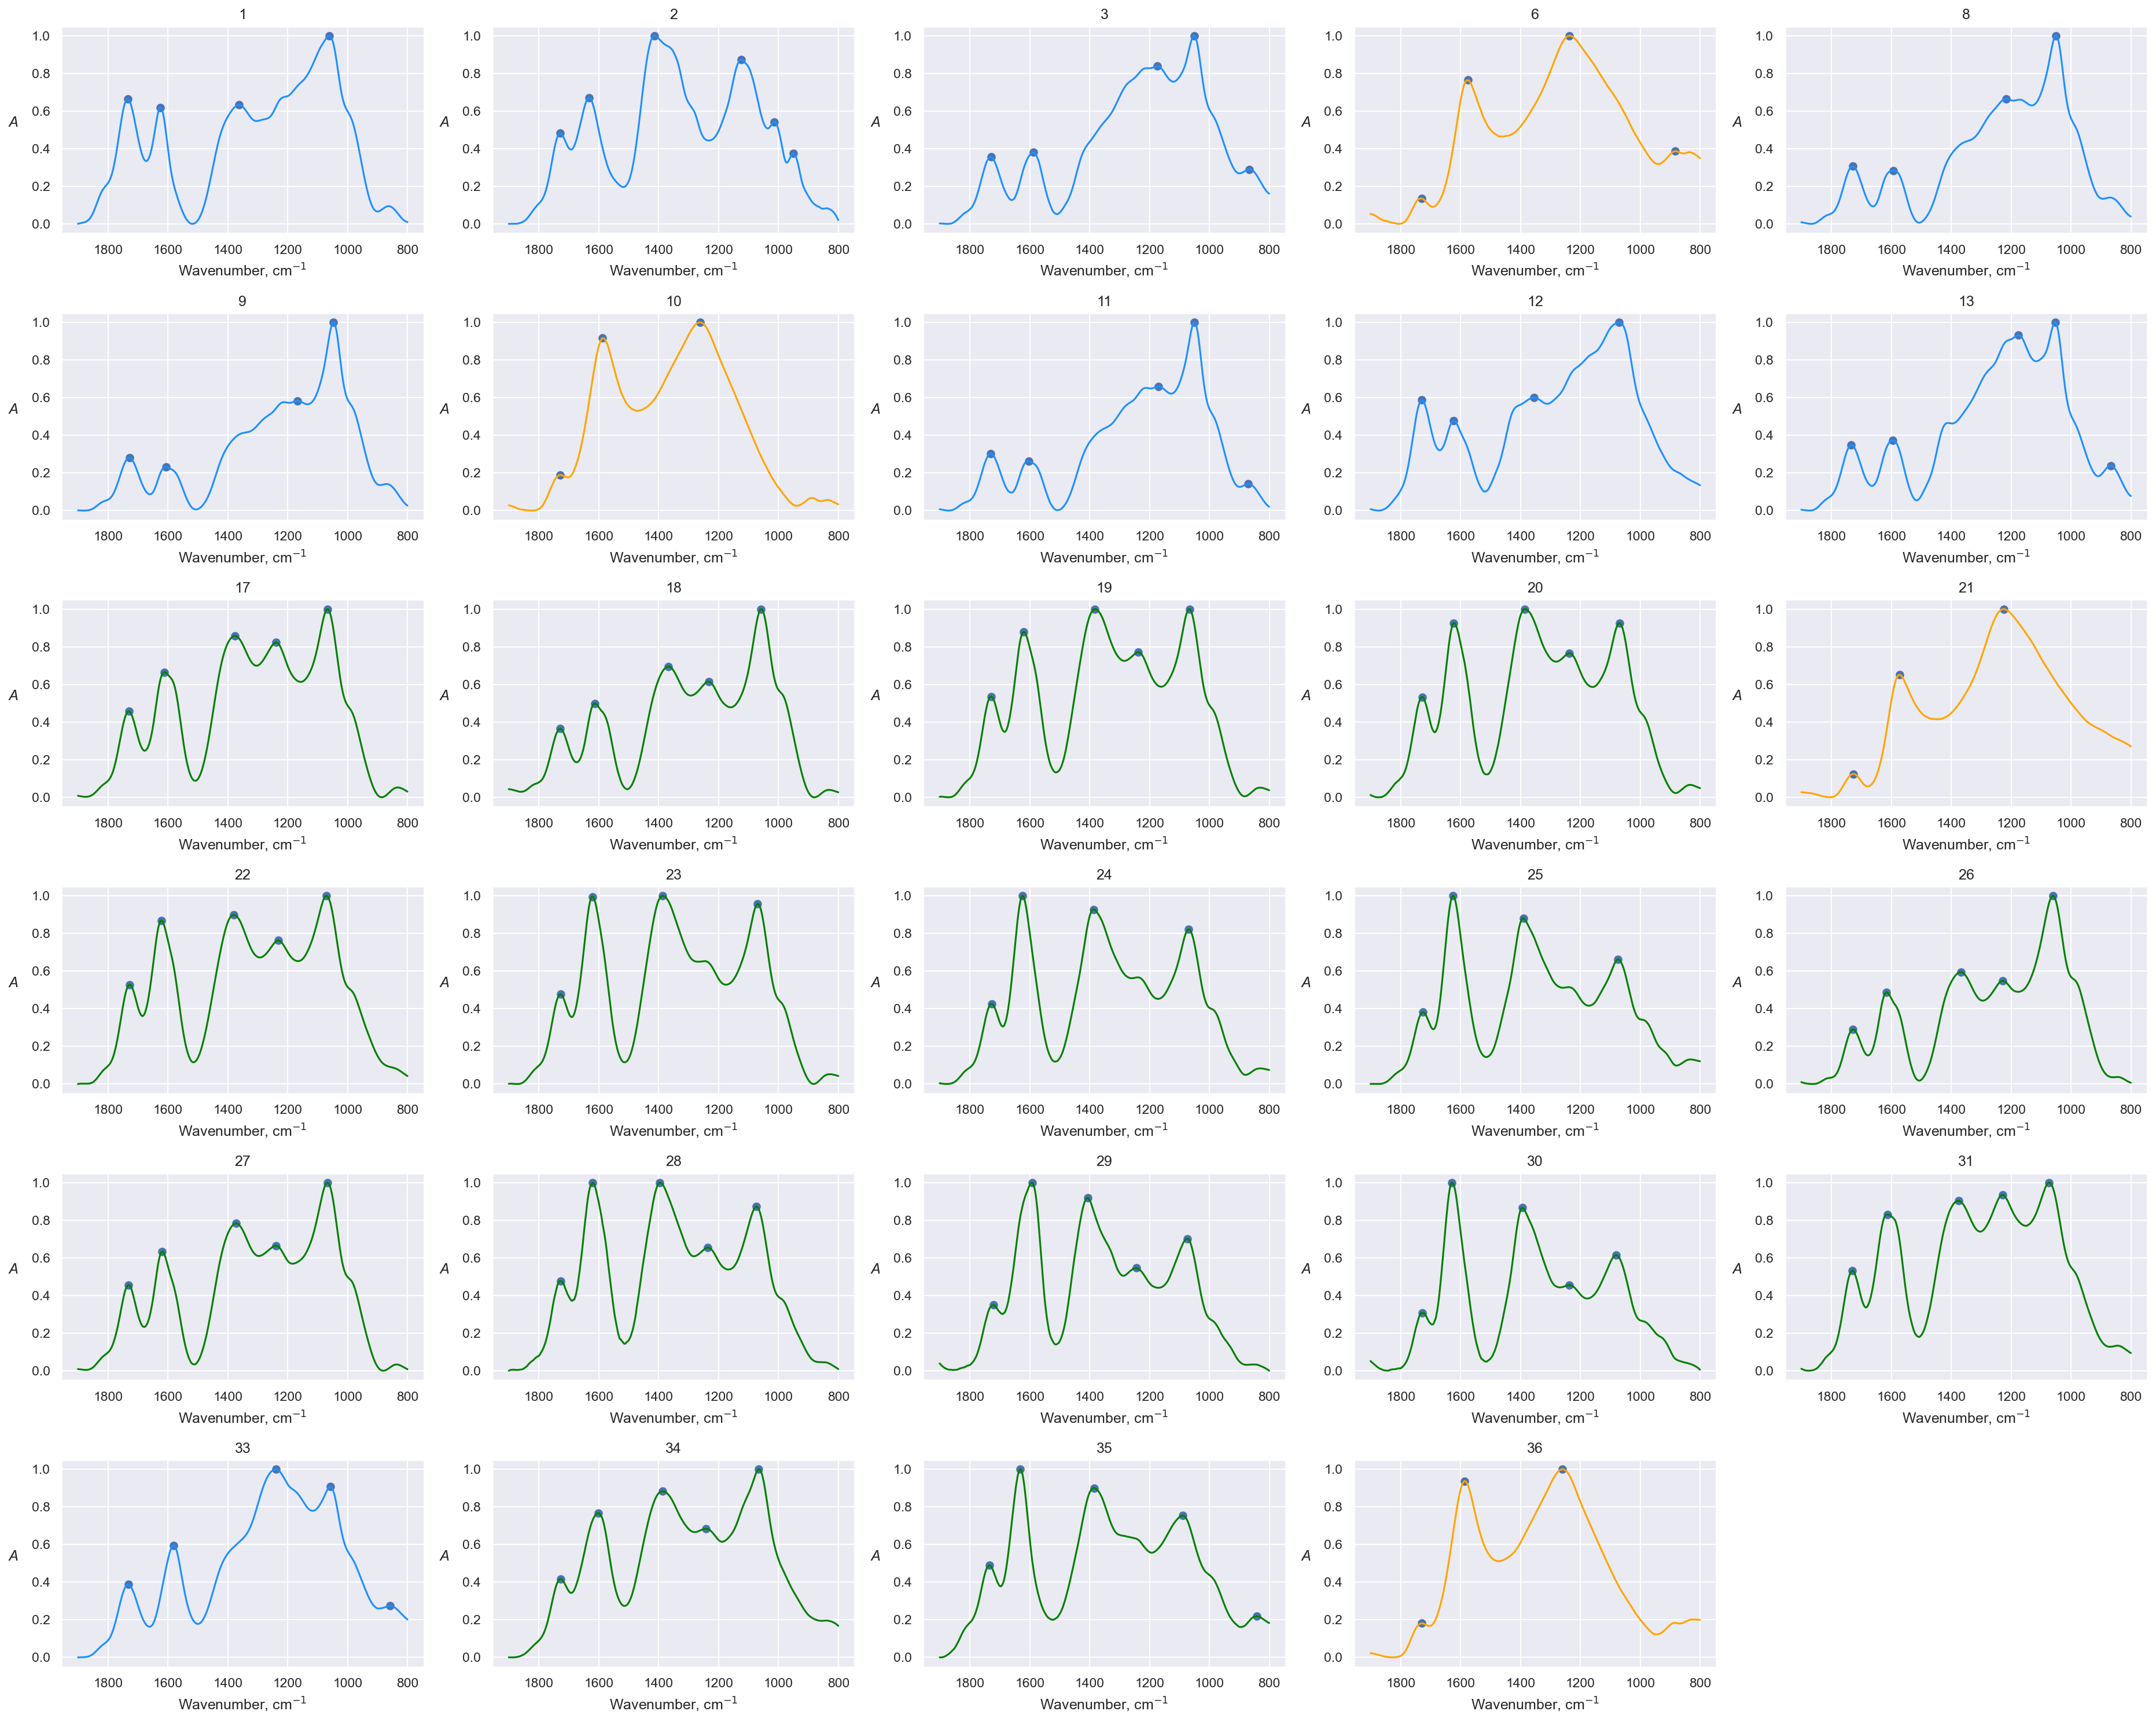

In [11]:
# visualizing spectra and peaks

unique_types = samples_description['Type'].unique()
colors = ['dodgerblue', 'orange', 'green']

type_color = dict(zip(unique_types, colors))

fontstyle = 'italic'
fontsize=12

sns.set_theme()
fig = plt.figure(figsize=(25, 20), dpi=150)

nrows = 6
ncols = 5

for i, idx in enumerate(absorbance.index):
    spectrum = absorbance.loc[idx].to_numpy()
    peaks_wavenumber = id_wavenumber_peaks_dict[idx]
    peaks_spectrum = id_spectrum_peaks_dict[idx]

    type = samples_description.loc[idx]['Type']
    color = type_color[type]

    ax = plt.subplot(nrows, ncols, i+1)

    ax.set_title(idx)
    
    ax.plot(wavenumber, spectrum, color=color, label=type)
    ax.scatter(peaks_wavenumber, peaks_spectrum)

    ax.set_xlabel('Wavenumber, cm$^{-1}$', fontstyle='normal', fontsize=fontsize, labelpad=5)
    ax.set_ylabel('A', fontstyle=fontstyle, fontsize=fontsize, labelpad=15, rotation=0)
    
    ax.invert_xaxis()
        
    plt.tight_layout()

plt.savefig(f'{path_to_save}/spectra_with_peaks.png', dpi=600)

In [12]:
# set that contain all peaks
all_wavenumber_peaks = []

for i, idx in enumerate(absorbance.index):
    peaks_wavenumber = id_wavenumber_peaks_dict[idx]
    all_wavenumber_peaks.extend(peaks_wavenumber)

all_wavenumber_peaks = sorted(set(all_wavenumber_peaks))

all_wavenumber_peaks_df = pd.DataFrame({'$Wavenumber_{peak}$': all_wavenumber_peaks}).T
all_wavenumber_peaks_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
$Wavenumber_{peak}$,840.92769,859.25066,866.96559,867.92996,869.85869,883.35982,950.86548,1013.54931,1047.30215,1050.19525,1051.15961,1053.08835,1057.91018,1060.80328,1061.76765,1065.62511,1066.58948,1067.55384,1069.48258,1070.44694,1071.41131,1073.34004,1074.30441,1080.09061,1089.73428,1125.41584,1167.84797,1170.74107,1173.63417,1175.56291,1217.03067,1224.7456,1228.60307,1231.49617,1233.4249,1236.318,1237.28237,1239.2111,1240.17547,1242.1042,...,1390.61666,1393.50976,1396.40286,1406.04653,1413.76146,1572.88195,1575.77505,1581.56125,1586.38308,1587.34745,1592.16928,1593.13365,1596.02675,1601.81295,1603.74168,1606.63478,1611.45662,1613.38535,1616.27845,1619.17155,1620.13592,1621.10028,1622.06465,1623.02902,1623.99338,1624.95775,1628.81522,1631.70831,1632.67268,1720.43004,1725.25188,1727.18061,1728.14498,1729.10934,1730.07371,1731.03808,1732.00244,1732.96681,1733.93118,1734.89554


## Functions for calculating peak area

In [13]:
def find_width(y, height=0.1, prominence=0.01, rel_height=1):
    peaks, _ = find_peaks(y, height=height, prominence=prominence)
    result = peak_widths(y, peaks, rel_height=rel_height)
    width = result[1:]
    if len(width[0]) == 0:
        pass
    else:
        wavenumber_lst = wavenumber.tolist()
        width = list(width)
        width[1] = [wavenumber_lst[+floor(i)] for i in width[1]]
        width[2] = [wavenumber_lst[+floor(i)] for i in width[2]]
        width = tuple(width)
    return width  # (y, x_min, x_max)

In [14]:
def integrate_peaks(x, y, height=0.1, prominence=0.01, rel_height=0.5):
    p, _ = find_peaks(y, height=height, prominence=prominence)
    peaks_positions = [x[j] for j in p]
    
    peak_area_dict = {}
    
    x1_lst, x2_lst = find_width(y, height=height, prominence=prominence, rel_height=rel_height)[1:]
    
    for peak_position, x1, x2 in zip(peaks_positions, x1_lst, x2_lst):
        i_start = x.index(x1)
        i_end = x.index(x2)
        y_integrate = y[i_start:i_end+1]
        x_integrate = x[i_start:i_end+1]
        y_rectangle = [y_integrate[0]] * len(y_integrate)
        full_area = abs(simpson(y_integrate, x_integrate))
        rectangle_area = abs(simpson(y_rectangle, x_integrate))
        area = full_area - rectangle_area
        peak_area_dict[peak_position] = area
    return peak_area_dict

## Extracating features

In [15]:
# calculating total area and intensity
total_intensity = [round(sum(intensity), 4) for intensity in id_spectrum_peaks_dict.values()]
total_area = [sum(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values()) for idx in absorbance.index]

# calculating intensity and area for band 1620 (c=c)
peak_intensity_cc = [intensities[1] for intensities in id_spectrum_peaks_dict.values()]
peak_area_cc = [list(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values())[1] for idx in absorbance.index]

# calculating intensity and area for band 1730 (c=o)
peak_intensity_co = [intensities[0] for intensities in id_spectrum_peaks_dict.values()]
peak_area_co = [list(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values())[0] for idx in absorbance.index]

In [16]:
base_features_dict = {
    '$ΣI$': total_intensity,
    '$ΣS$': total_area,
    '$I_{1619}$': peak_intensity_cc,
    '$S_{1619}$': peak_area_cc,
    '$I_{1720}$': peak_intensity_co,
    '$S_{1720}$': peak_area_co
}

base_features = pd.DataFrame(base_features_dict, index=data.index[1:])

print(base_features.shape)
base_features.head(3)

(29, 6)


,$ΣI$,$ΣS$,$I_{1619}$,$S_{1619}$,$I_{1720}$,$S_{1720}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582


# Descriprive statistics of base (extracted) features

## Dataset preparation

*Selecting data for visualization of distribution but only `train` subsample*

In [17]:
parameters = base_features.columns
train_indexes_lst = samples_description.loc[samples_description['Label'] == 'Train'].index

In [18]:
vis_data = base_features.copy().loc[train_indexes_lst]
vis_data['Type'] = samples_description.loc[train_indexes_lst]['Type']

print(vis_data.shape)
vis_data.head(3)

(25, 7)


,$ΣI$,$ΣS$,$I_{1619}$,$S_{1619}$,$I_{1720}$,$S_{1720}$,Type
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,$ОГ$
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,$ОГ$
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,$ОГ$


## BoxPlot

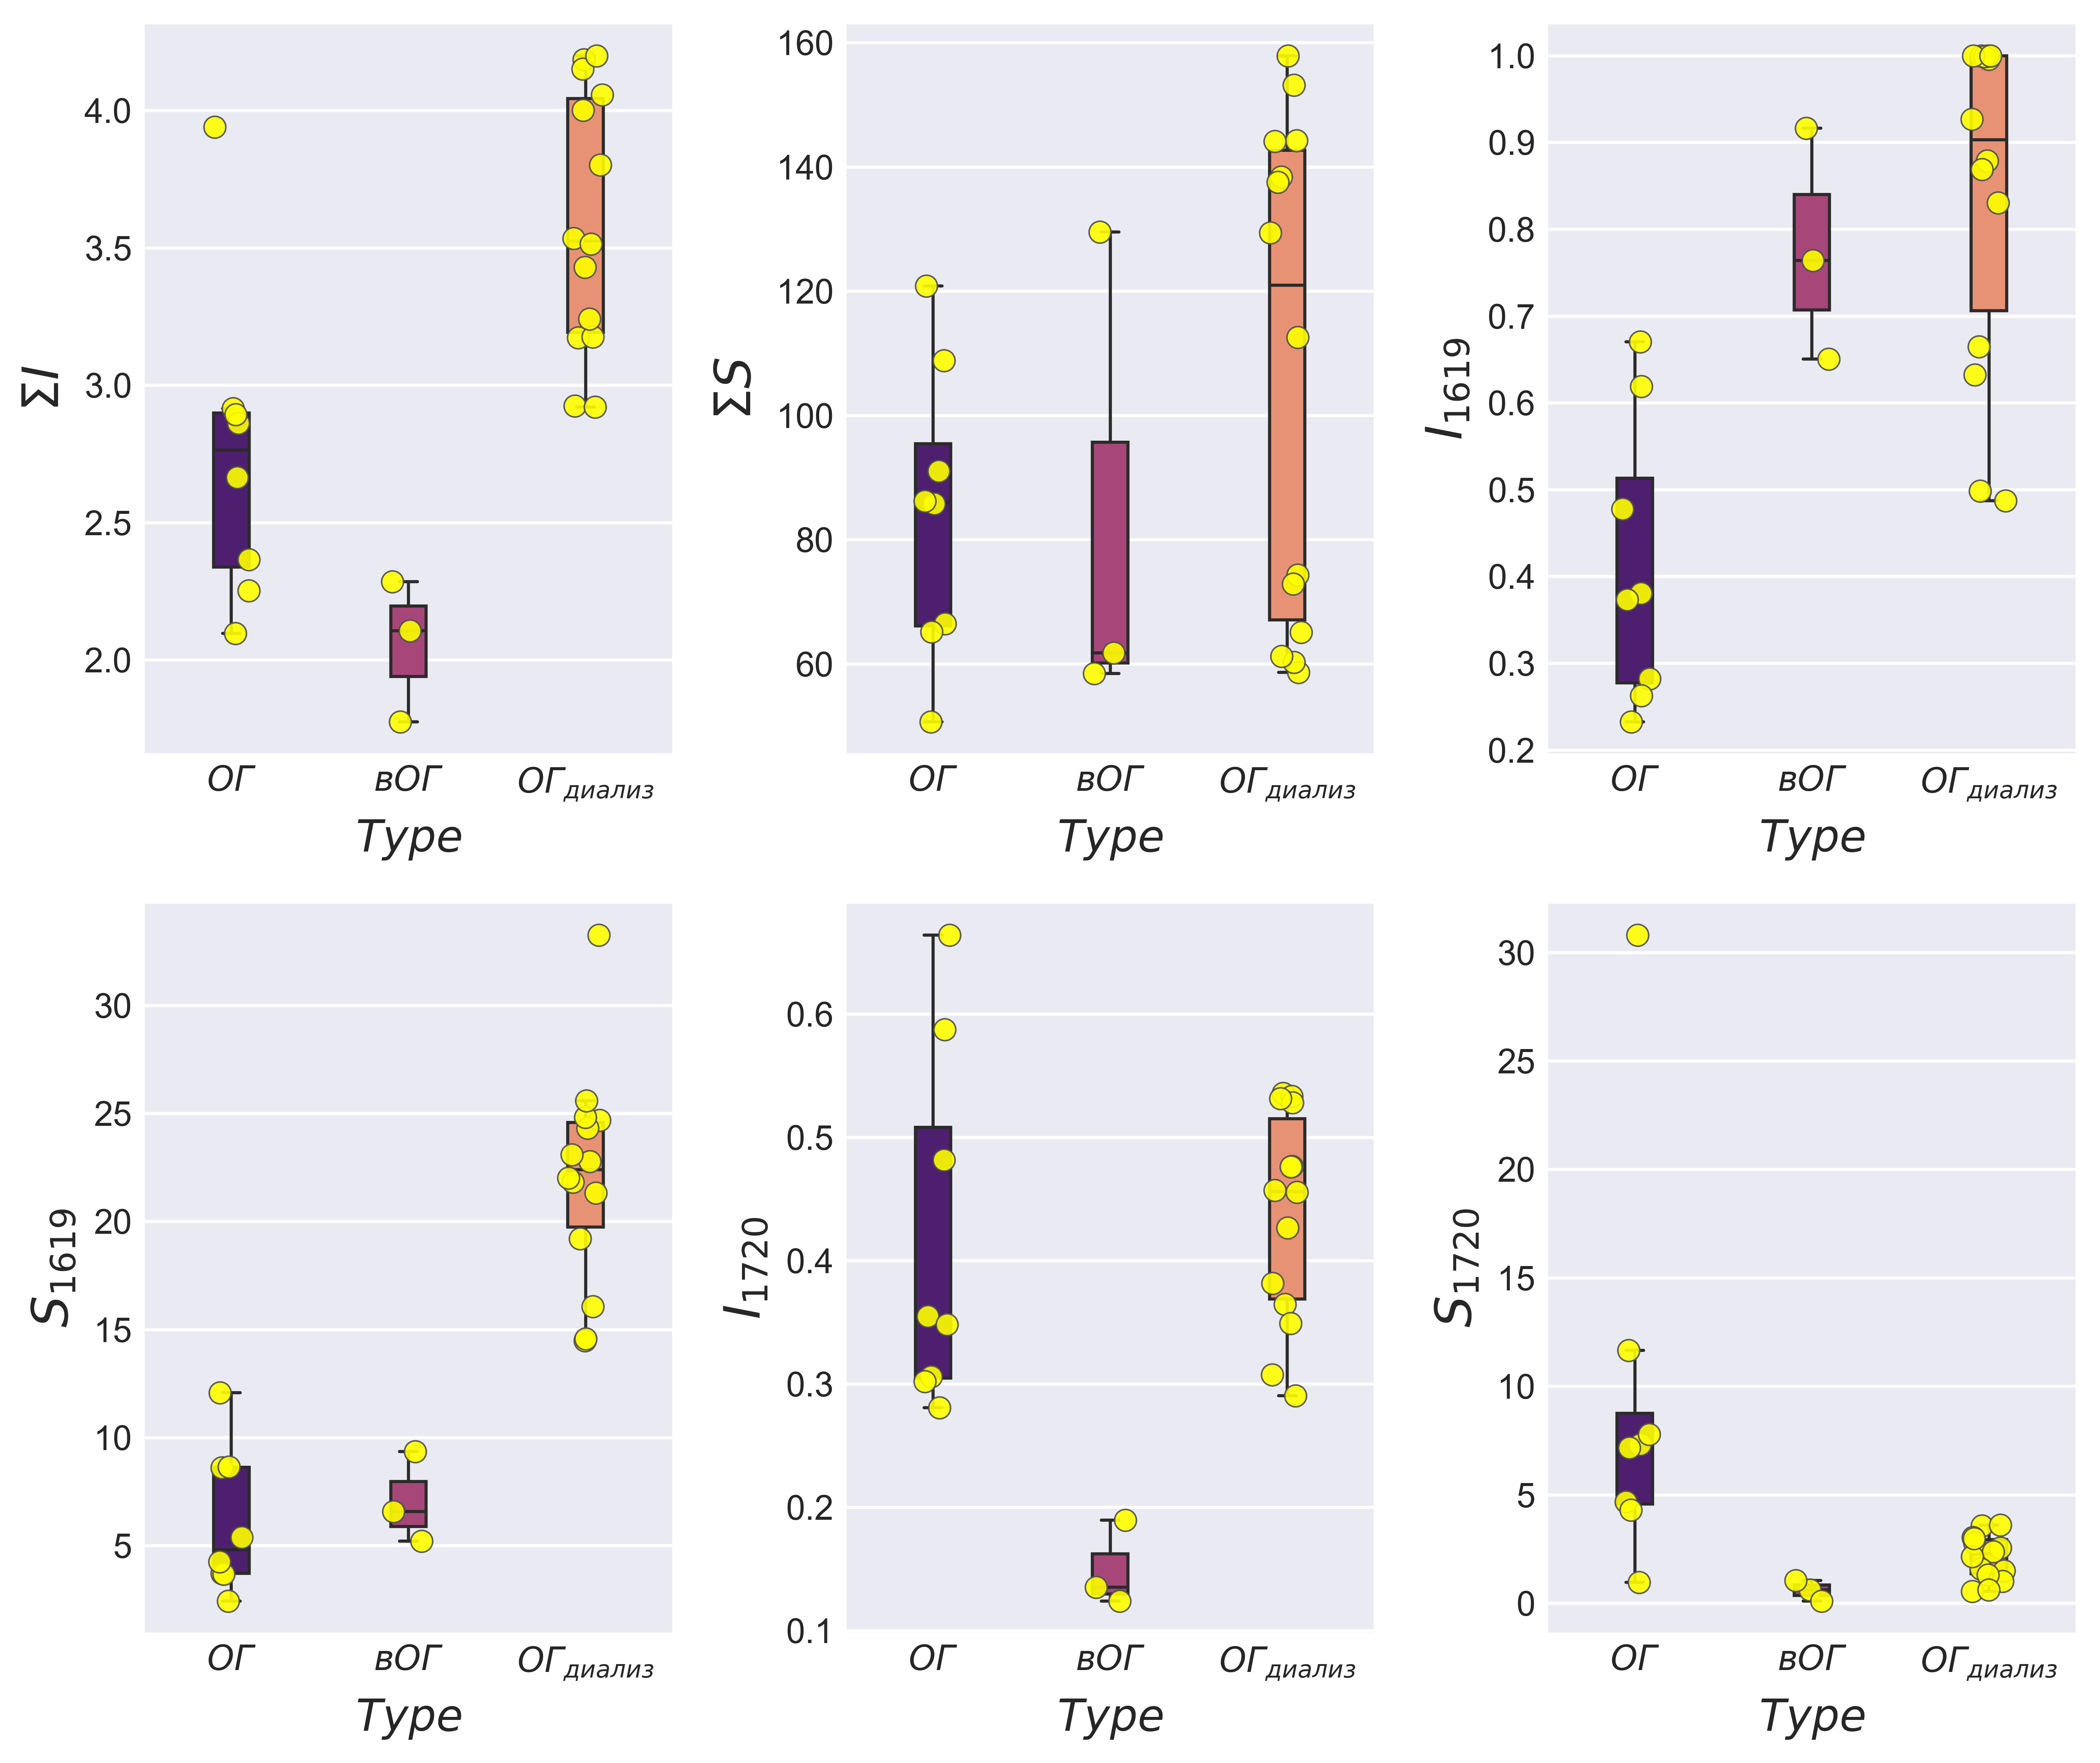

In [19]:
sns.set_theme()
# plt.style.use('seaborn-v0_8-darkgrid')

nrows = 2
ncols = (vis_data.shape[1] - 1) // 2

point_size = 7
point_alpha = 0.9


fig = plt.figure(figsize=(9.5, 8), dpi=600, linewidth=1.0)

for i, parameter in enumerate(parameters):
    ax = plt.subplot(nrows, ncols, i+1)

    ax.grid(True)
    ax.tick_params(direction='in')

    # palette = ['inferno', 'cubehelix', 'Spectral', 'viridis', 'seismic', 'magma']

    sns.boxplot(data=vis_data,
                x='Type',
                y=parameter,
                width=0.2,
                palette='magma',
                showfliers=False,
                ax=ax)

    sns.stripplot(data=vis_data,
                  x='Type',
                  y=parameter,
                  color='yellow',
                  alpha=point_alpha,
                  s=point_size,
                  linewidth=0.5,
                  ax=ax)

    ax.set_ylabel(parameter,
                  fontsize=16,
                  rotation=90,
                  labelpad=5)
    
    ax.set_xlabel('$Type$',
                  fontsize=14,
                  rotation=0,
                  labelpad=5)

plt.tight_layout()

plt.savefig(f'{path_to_save}/boxplot.png', dpi=600)
plt.show()

## ViolinPlot

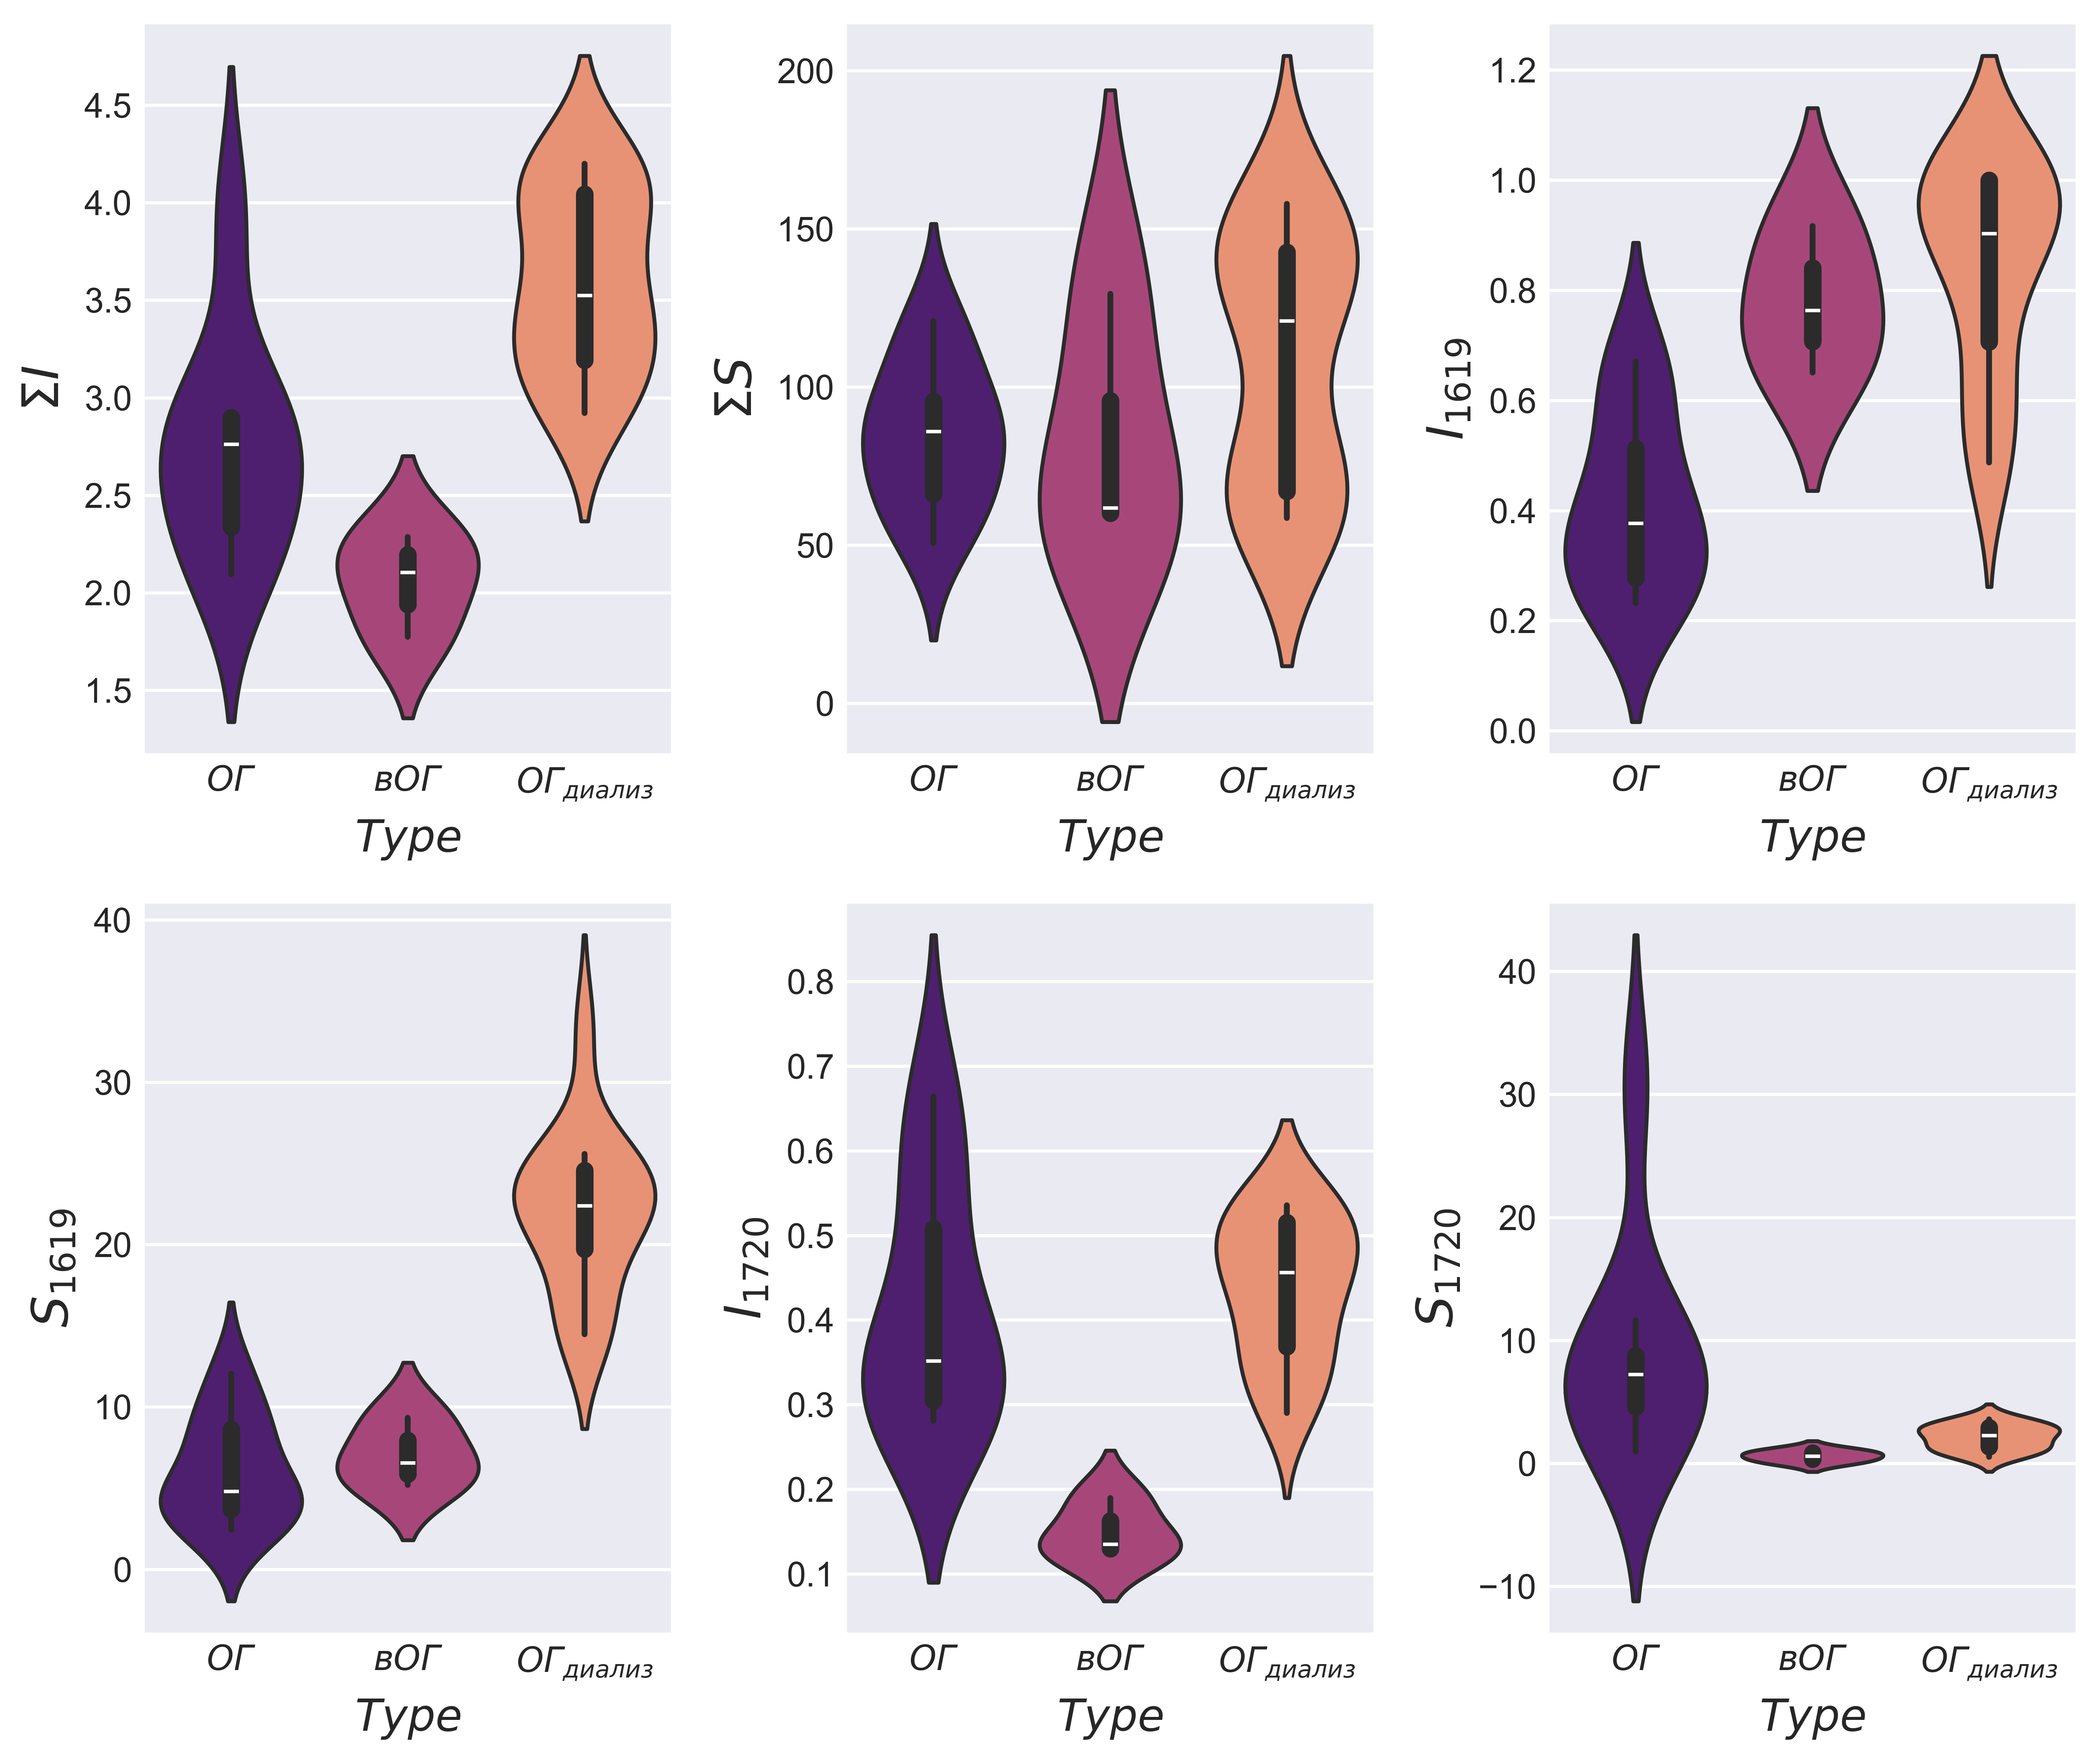

In [20]:
sns.set_theme()
# plt.style.use('seaborn-v0_8-darkgrid')

nrows = 2
ncols = (vis_data.shape[1] - 1) // 2

point_size = 7
point_alpha = 0.9


fig = plt.figure(figsize=(9.5, 8), dpi=600, linewidth=1.0)

for i, parameter in enumerate(parameters):
    ax = plt.subplot(nrows, ncols, i+1)

    ax.grid(True)
    ax.tick_params(direction='in')

    # palette = ['inferno', 'cubehelix', 'Spectral', 'viridis', 'seismic', 'magma']

    sns.violinplot(data=vis_data,
                   x='Type',
                   y=parameter,
                   palette='magma',
                   ax=ax)

    ax.set_ylabel(parameter,
                  fontsize=16,
                  rotation=90,
                  labelpad=5)
    
    ax.set_xlabel('$Type$',
                  fontsize=14,
                  rotation=0,
                  labelpad=5)

plt.tight_layout()

plt.savefig(path_to_save + '/violinplot.png', dpi=600)
plt.show()

# Feature engineering

In [21]:
dict_initial_raw = dict(zip(base_features.columns, ['ΣI', 'ΣS', 'I_{1619}', 'S_{1619}', 'I_{1720}', 'S_{1720}']))

dict_columns = dict(zip(base_features.columns, ['$(ΣI)_{n}$', '$(ΣS)_{n}$', '$I_{1619, n}$', '$S_{1619, n}$', '$I_{1720, n}$', '$S_{1720, n}$']))

engineered_data = base_features.copy().rename(columns=dict_columns)

## Combining features as a *quotient of division*

In [22]:
for i, feature1 in enumerate(base_features.columns):
    feature1_raw = dict_initial_raw[feature1]
    
    for j, feature2 in enumerate(base_features.columns):
        if j <= i:
            continue
        else:
            feature2_raw = dict_initial_raw[feature2]
            new_feature_name = r'$(\frac{' + feature1_raw + '}{' + feature2_raw + '})_{n}$'
            new_feature_value = base_features[feature1] / base_features[feature2]

            engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

(29, 21)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,0.024117,4.708838,0.783430,4.390159,0.094618,195.247462,32.484193,182.033770,3.923244,0.166374,0.932323,0.020094,5.603765,0.120774,0.021552
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,0.043276,5.876673,0.326323,8.177088,4.049420,135.794536,7.540462,188.951098,93.571485,0.055528,1.391448,0.689067,25.058291,12.409251,0.495215
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,0.033361,7.522086,0.332542,8.061920,0.611503,225.472431,9.967844,241.653809,18.329623,0.044209,1.071767,0.081294,24.243337,1.838875,0.075851


## Raising features to power *n* and –*n*

In [23]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$({feature1_raw}^' + '{' + f'{-1}' + '})_{n}$'
    new_feature_value = base_features[feature1] ** (-1)
    engineered_data[new_feature_name] = new_feature_value

    for n in range(2, 6):
        new_feature_name = f'$({feature1_raw}^' + f'{n}' + ')_{n}$'
        new_feature_value = base_features[feature1] ** (n)
        engineered_data[new_feature_name] = new_feature_value

        new_feature_name = f'$({feature1_raw}^' + '{' + f'{-n}' + '})_{n}$'
        new_feature_value = base_features[feature1] ** (-n)
        engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

(29, 75)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,$(ΣI^{-3})_{n}$,$(ΣI^4)_{n}$,$(ΣI^{-4})_{n}$,$(ΣI^5)_{n}$,$(ΣI^{-5})_{n}$,$(ΣS^{-1})_{n}$,$(ΣS^2)_{n}$,$(ΣS^{-2})_{n}$,$(ΣS^3)_{n}$,$(ΣS^{-3})_{n}$,$(ΣS^4)_{n}$,$(ΣS^{-4})_{n}$,$(ΣS^5)_{n}$,$(ΣS^{-5})_{n}$,$(I_{1619}^{-1})_{n}$,$(I_{1619}^2)_{n}$,$(I_{1619}^{-2})_{n}$,$(I_{1619}^3)_{n}$,$(I_{1619}^{-3})_{n}$,$(I_{1619}^4)_{n}$,$(I_{1619}^{-4})_{n}$,$(I_{1619}^5)_{n}$,$(I_{1619}^{-5})_{n}$,$(S_{1619}^{-1})_{n}$,$(S_{1619}^2)_{n}$,$(S_{1619}^{-2})_{n}$,$(S_{1619}^3)_{n}$,$(S_{1619}^{-3})_{n}$,$(S_{1619}^4)_{n}$,$(S_{1619}^{-4})_{n}$,$(S_{1619}^5)_{n}$,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,0.024117,4.708838,0.783430,4.390159,0.094618,195.247462,32.484193,182.033770,3.923244,0.166374,0.932323,0.020094,5.603765,0.120774,0.021552,0.343041,8.497808,0.117677,24.771960,0.040368,72.212741,0.013848,210.507361,0.004750,0.008273,14610.001532,0.000068,1.765938e+06,5.662714e-07,2.134521e+08,4.684891e-09,2.580035e+10,3.875916e-11,1.615326,0.383248,2.609279,0.237257,4.214837,0.146879,6.808337,0.090928,10.997686,0.268749,13.845419,0.072226,51.518018,0.019411,191.695622,0.005217,713.288536,0.001402,1.506006,0.440906,2.268055,0.292765,3.415706,0.194398,5.144075,0.129082,7.747011,0.032458,949.204210,0.001054,29244.182358,0.000034,900988.631502,0.000001,2.775870e+07,3.602474e-08
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,0.043276,5.876673,0.326323,8.177088,4.049420,135.794536,7.540462,188.951098,93.571485,0.055528,1.391448,0.689067,25.058291,12.409251,0.495215,0.253820,15.522024,0.064425,61.153670,0.016352,240.933230,0.004151,949.228741,0.001053,0.010984,8288.001489,0.000121,7.545269e+05,1.325334e-06,6.869097e+07,1.455795e-08,6.253520e+09,1.599099e-10,1.491617,0.449454,2.224922,0.301320,3.318732,0.202009,4.950277,0.135429,7.383919,0.082827,145.765209,0.006860,1759.870945,0.000568,21247.496278,0.000047,256527.956928,0.000004,2.075508,0.232141,4.307735,0.111848,8.940741,0.053889,18.556584,0.025964,38.514347,1.027824,0.946592,1.056421,0.920967,1.085815,0.896036,1.116026,8.717801e-01,1.147078e+00
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,0.033361,7.522086,0.332542,8.061920,0.611503,225.472431,9.967844,241.653809,18.329623,0.044209,1.071767,0.081294,24.243337,1.838875,0.075851,0.349308,8.195624,0.122016,23.462432,0.042621,67.168250,0.014888,192.289266,0.005200,0.011653,7363.636664,0.000136,6.318857e+05,1.582565e-06,5.422314e+07,1.844231e-08,4.652977e+09,2.149162e-10,2.627528,0.144846,6.903901,0.055126,18.140189,0.020980,47.663847,0.007985,125.238069,0.116160,74.112225,0.013493,638.020707,0.001567,5492.621828,0.000182,47285.133895,0.000021,2.816096,0.126097,7.930397,0.044777,22.332761,0.015900,62.891200,0.005646,177.107662,0.213603,21.917211,0.045626,102.607222,0.009746,480.364133,0.002082,2.248864e+03,4.446689e-04


## *Logarithm* of features

In [24]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$(ln|{feature1_raw}|' + ')_{n}$'
    new_feature_value = np.log(np.abs(base_features[feature1]))
    engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

(29, 81)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,$(ΣI^{-3})_{n}$,$(ΣI^4)_{n}$,$(ΣI^{-4})_{n}$,$(ΣI^5)_{n}$,$(ΣI^{-5})_{n}$,$(ΣS^{-1})_{n}$,$(ΣS^2)_{n}$,$(ΣS^{-2})_{n}$,$(ΣS^3)_{n}$,$(ΣS^{-3})_{n}$,$(ΣS^4)_{n}$,$(ΣS^{-4})_{n}$,$(ΣS^5)_{n}$,$(ΣS^{-5})_{n}$,$(I_{1619}^{-1})_{n}$,...,$(I_{1619}^{-2})_{n}$,$(I_{1619}^3)_{n}$,$(I_{1619}^{-3})_{n}$,$(I_{1619}^4)_{n}$,$(I_{1619}^{-4})_{n}$,$(I_{1619}^5)_{n}$,$(I_{1619}^{-5})_{n}$,$(S_{1619}^{-1})_{n}$,$(S_{1619}^2)_{n}$,$(S_{1619}^{-2})_{n}$,$(S_{1619}^3)_{n}$,$(S_{1619}^{-3})_{n}$,$(S_{1619}^4)_{n}$,$(S_{1619}^{-4})_{n}$,$(S_{1619}^5)_{n}$,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$,$(ln|ΣI|)_{n}$,$(ln|ΣS|)_{n}$,$(ln|I_{1619}|)_{n}$,$(ln|S_{1619}|)_{n}$,$(ln|I_{1720}|)_{n}$,$(ln|S_{1720}|)_{n}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,0.024117,4.708838,0.783430,4.390159,0.094618,195.247462,32.484193,182.033770,3.923244,0.166374,0.932323,0.020094,5.603765,0.120774,0.021552,0.343041,8.497808,0.117677,24.771960,0.040368,72.212741,0.013848,210.507361,0.004750,0.008273,14610.001532,0.000068,1.765938e+06,5.662714e-07,2.134521e+08,4.684891e-09,2.580035e+10,3.875916e-11,1.615326,...,2.609279,0.237257,4.214837,0.146879,6.808337,0.090928,10.997686,0.268749,13.845419,0.072226,51.518018,0.019411,191.695622,0.005217,713.288536,0.001402,1.506006,0.440906,2.268055,0.292765,3.415706,0.194398,5.144075,0.129082,7.747011,0.032458,949.204210,0.001054,29244.182358,0.000034,900988.631502,0.000001,2.775870e+07,3.602474e-08,1.069904,4.794731,-0.479537,1.313977,-0.409461,3.427812
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,0.043276,5.876673,0.326323,8.177088,4.049420,135.794536,7.540462,188.951098,93.571485,0.055528,1.391448,0.689067,25.058291,12.409251,0.495215,0.253820,15.522024,0.064425,61.153670,0.016352,240.933230,0.004151,949.228741,0.001053,0.010984,8288.001489,0.000121,7.545269e+05,1.325334e-06,6.869097e+07,1.455795e-08,6.253520e+09,1.599099e-10,1.491617,...,2.224922,0.301320,3.318732,0.202009,4.950277,0.135429,7.383919,0.082827,145.765209,0.006860,1759.870945,0.000568,21247.496278,0.000047,256527.956928,0.000004,2.075508,0.232141,4.307735,0.111848,8.940741,0.053889,18.556584,0.025964,38.514347,1.027824,0.946592,1.056421,0.920967,1.085815,0.896036,1.116026,8.717801e-01,1.147078e+00,1.371130,4.511282,-0.399861,2.490999,-0.730206,-0.027444
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,0.033361,7.522086,0.332542,8.061920,0.611503,225.472431,9.967844,241.653809,18.329623,0.044209,1.071767,0.081294,24.243337,1.838875,0.075851,0.349308,8.195624,0.122016,23.462432,0.042621,67.168250,0.014888,192.289266,0.005200,0.011653,7363.636664,0.000136,6.318857e+05,1.582565e-06,5.422314e+07,1.844231e-08,4.652977e+09,2.149162e-10,2.627528,...,6.903901,0.055126,18.140189,0.020980,47.663847,0.007985,125.238069,0.116160,74.112225,0.013493,638.020707,0.001567,5492.621828,0.000182,47285.133895,0.000021,2.816096,0.126097,7.930397,0.044777,22.332761,0.015900,62.891200,0.005646,177.107662,0.213603,21.917211,0.045626,102.607222,0.009746,480.364133,0.002082,2.248864e+03,4.446689e-04,1.051800,4.452155,-0.966043,2.15

*Saving features before scaling*

# Final data transormations

## Splitting data to *train/test*

In [25]:
train_indexes_lst = samples_description.loc[samples_description['Label'] == 'Train'].index
test_indexes_lst = samples_description.loc[samples_description['Label'] == 'Test'].index

In [26]:
engineered_data_train = engineered_data.loc[train_indexes_lst]

print(engineered_data_train.shape)
engineered_data_train.head(3)

(25, 81)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,$(ΣI^{-3})_{n}$,$(ΣI^4)_{n}$,$(ΣI^{-4})_{n}$,$(ΣI^5)_{n}$,$(ΣI^{-5})_{n}$,$(ΣS^{-1})_{n}$,$(ΣS^2)_{n}$,$(ΣS^{-2})_{n}$,$(ΣS^3)_{n}$,$(ΣS^{-3})_{n}$,$(ΣS^4)_{n}$,$(ΣS^{-4})_{n}$,$(ΣS^5)_{n}$,$(ΣS^{-5})_{n}$,$(I_{1619}^{-1})_{n}$,...,$(I_{1619}^{-2})_{n}$,$(I_{1619}^3)_{n}$,$(I_{1619}^{-3})_{n}$,$(I_{1619}^4)_{n}$,$(I_{1619}^{-4})_{n}$,$(I_{1619}^5)_{n}$,$(I_{1619}^{-5})_{n}$,$(S_{1619}^{-1})_{n}$,$(S_{1619}^2)_{n}$,$(S_{1619}^{-2})_{n}$,$(S_{1619}^3)_{n}$,$(S_{1619}^{-3})_{n}$,$(S_{1619}^4)_{n}$,$(S_{1619}^{-4})_{n}$,$(S_{1619}^5)_{n}$,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$,$(ln|ΣI|)_{n}$,$(ln|ΣS|)_{n}$,$(ln|I_{1619}|)_{n}$,$(ln|S_{1619}|)_{n}$,$(ln|I_{1720}|)_{n}$,$(ln|S_{1720}|)_{n}$
1,2.9151,120.871839,0.619070,3.720943,0.664008,30.809158,0.024117,4.708838,0.783430,4.390159,0.094618,195.247462,32.484193,182.033770,3.923244,0.166374,0.932323,0.020094,5.603765,0.120774,0.021552,0.343041,8.497808,0.117677,24.771960,0.040368,72.212741,0.013848,210.507361,0.004750,0.008273,14610.001532,0.000068,1.765938e+06,5.662714e-07,2.134521e+08,4.684891e-09,2.580035e+10,3.875916e-11,1.615326,...,2.609279,0.237257,4.214837,0.146879,6.808337,0.090928,10.997686,0.268749,13.845419,0.072226,51.518018,0.019411,191.695622,0.005217,713.288536,0.001402,1.506006,0.440906,2.268055,0.292765,3.415706,0.194398,5.144075,0.129082,7.747011,0.032458,949.204210,0.001054,29244.182358,0.000034,900988.631502,0.000001,2.775870e+07,3.602474e-08,1.069904,4.794731,-0.479537,1.313977,-0.409461,3.427812
2,3.9398,91.038462,0.670413,12.073326,0.481810,0.972930,0.043276,5.876673,0.326323,8.177088,4.049420,135.794536,7.540462,188.951098,93.571485,0.055528,1.391448,0.689067,25.058291,12.409251,0.495215,0.253820,15.522024,0.064425,61.153670,0.016352,240.933230,0.004151,949.228741,0.001053,0.010984,8288.001489,0.000121,7.545269e+05,1.325334e-06,6.869097e+07,1.455795e-08,6.253520e+09,1.599099e-10,1.491617,...,2.224922,0.301320,3.318732,0.202009,4.950277,0.135429,7.383919,0.082827,145.765209,0.006860,1759.870945,0.000568,21247.496278,0.000047,256527.956928,0.000004,2.075508,0.232141,4.307735,0.111848,8.940741,0.053889,18.556584,0.025964,38.514347,1.027824,0.946592,1.056421,0.920967,1.085815,0.896036,1.116026,8.717801e-01,1.147078e+00,1.371130,4.511282,-0.399861,2.490999,-0.730206,-0.027444
3,2.8628,85.811635,0.380586,8.608846,0.355102,4.681582,0.033361,7.522086,0.332542,8.061920,0.611503,225.472431,9.967844,241.653809,18.329623,0.044209,1.071767,0.081294,24.243337,1.838875,0.075851,0.349308,8.195624,0.122016,23.462432,0.042621,67.168250,0.014888,192.289266,0.005200,0.011653,7363.636664,0.000136,6.318857e+05,1.582565e-06,5.422314e+07,1.844231e-08,4.652977e+09,2.149162e-10,2.627528,...,6.903901,0.055126,18.140189,0.020980,47.663847,0.007985,125.238069,0.116160,74.112225,0.013493,638.020707,0.001567,5492.621828,0.000182,47285.133895,0.000021,2.816096,0.126097,7.930397,0.044777,22.332761,0.015900,62.891200,0.005646,177.107662,0.213603,21.917211,0.045626,102.607222,0.009746,480.364133,0.002082,2.248864e+03,4.446689e-04,1.051800,4.452155,-0.966043,2.15

In [27]:
engineered_data_test = engineered_data.loc[test_indexes_lst]

print(engineered_data_test.shape)
engineered_data_test.head(3)

(4, 81)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,$(ΣI^{-3})_{n}$,$(ΣI^4)_{n}$,$(ΣI^{-4})_{n}$,$(ΣI^5)_{n}$,$(ΣI^{-5})_{n}$,$(ΣS^{-1})_{n}$,$(ΣS^2)_{n}$,$(ΣS^{-2})_{n}$,$(ΣS^3)_{n}$,$(ΣS^{-3})_{n}$,$(ΣS^4)_{n}$,$(ΣS^{-4})_{n}$,$(ΣS^5)_{n}$,$(ΣS^{-5})_{n}$,$(I_{1619}^{-1})_{n}$,...,$(I_{1619}^{-2})_{n}$,$(I_{1619}^3)_{n}$,$(I_{1619}^{-3})_{n}$,$(I_{1619}^4)_{n}$,$(I_{1619}^{-4})_{n}$,$(I_{1619}^5)_{n}$,$(I_{1619}^{-5})_{n}$,$(S_{1619}^{-1})_{n}$,$(S_{1619}^2)_{n}$,$(S_{1619}^{-2})_{n}$,$(S_{1619}^3)_{n}$,$(S_{1619}^{-3})_{n}$,$(S_{1619}^4)_{n}$,$(S_{1619}^{-4})_{n}$,$(S_{1619}^5)_{n}$,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$,$(ln|ΣI|)_{n}$,$(ln|ΣS|)_{n}$,$(ln|I_{1619}|)_{n}$,$(ln|S_{1619}|)_{n}$,$(ln|I_{1720}|)_{n}$,$(ln|S_{1720}|)_{n}$
33,3.1646,98.905036,0.595940,9.150733,0.387241,4.742433,0.031996,5.310265,0.345830,8.172179,0.667295,165.964730,10.808428,255.409747,20.855338,0.065125,1.538940,0.125661,23.630611,1.929544,0.081654,0.315996,10.014693,0.099853,31.692498,0.031553,100.294079,0.009971,317.390643,0.003151,0.010111,9782.206237,0.000102,9.675095e+05,1.033582e-06,9.569156e+07,1.045024e-08,9.464377e+09,1.056594e-10,1.678021,...,2.815755,0.211645,4.724895,0.126128,7.928474,0.075165,13.304145,0.109281,83.735918,0.011942,766.245038,0.001305,7011.703883,0.000143,6.416223e+04,1.558549e-05,2.582374,0.149955,6.668653,0.058069,17.220953,0.022487,44.470933,0.008708,114.840560,0.210862,22.490667,0.044463,106.660472,0.009376,505.830097,0.001977,2398.865136,0.000417,1.152027,4.594160,-0.517615,2.213834,-0.948709,1.556550
34,3.7505,104.688202,0.766776,14.711741,0.417319,0.914859,0.035825,4.891261,0.254932,8.987125,4.099539,136.530404,7.115963,250.858818,114.430970,0.052120,1.837384,0.838135,35.252968,16.080883,0.456157,0.266631,14.066250,0.071092,52.755472,0.018955,197.859396,0.005054,742.071665,0.001348,0.009552,10959.619658,0.000091,1.147343e+06,8.715790e-07,1.201133e+08,8.325475e-09,1.257444e+10,7.952639e-11,1.304162,...,1.700839,0.450822,2.218170,0.345679,2.892854,0.265059,3.772751,0.067973,216.435313,0.004620,3184.140189,0.000314,46844.244648,0.000021,6.891604e+05,1.451041e-06,2.396247,0.174155,5.742001,0.072678,13.759254,0.030330,32.970575,0.012657,79.005650,1.093065,0.836967,1.194790,0.765707,1.305983,0.700514,1.427524,0.640871,1.560376,1.321889,4.650986,-0.265561,2.688646,-0.873904,-0.088985
35,3.3627,82.943196,1.000000,19.206562,0.489145,1.463460,0.040542,3.362700,0.175081,6.874645,2.297775,82.943196,4.318482,169.567615,56.676112,0.052066,2.044382,0.683312,39.265559,13.124082,0.334239,0.297380,11.307751,0.088435,38.024575,0.026299,127.865239,0.007821,429.972440,0.002326,0.012056,6879.573706,0.000145,5.706138e+05,1.752499e-06,4.732853e+07,2.112890e-08,3.925580e+09,2.547394e-10,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.052066,368.892034,0.002711,7085.147826,0.000141,136081.332903,0.000007,2.613655e+06,3.826060e-07,2.044382,0.239263,4.179500,0.117034,8.544496,0.057247,17.468218,0.028002,35.711718,0.683312,2.141714,0.466916,3.134311,0.319049,4.586938,0.218010,6.712798,0.148969,1.212744,4.418156,0.000000,2.955252,

## Scaling features (`train`)

In [28]:
columns = engineered_data_train.columns
indexes = engineered_data_train.index

In [29]:
scaler = MinMaxScaler()

engineered_data_train_scaled = pd.DataFrame(
    scaler.fit_transform(engineered_data_train), 
    columns=columns, 
    index=indexes
)

print(engineered_data_train_scaled.shape)
engineered_data_train_scaled.head(3)

(25, 81)


,$(ΣI)_{n}$,$(ΣS)_{n}$,"$I_{1619, n}$","$S_{1619, n}$","$I_{1720, n}$","$S_{1720, n}$",$(\frac{ΣI}{ΣS})_{n}$,$(\frac{ΣI}{I_{1619}})_{n}$,$(\frac{ΣI}{S_{1619}})_{n}$,$(\frac{ΣI}{I_{1720}})_{n}$,$(\frac{ΣI}{S_{1720}})_{n}$,$(\frac{ΣS}{I_{1619}})_{n}$,$(\frac{ΣS}{S_{1619}})_{n}$,$(\frac{ΣS}{I_{1720}})_{n}$,$(\frac{ΣS}{S_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1619}})_{n}$,$(\frac{I_{1619}}{I_{1720}})_{n}$,$(\frac{I_{1619}}{S_{1720}})_{n}$,$(\frac{S_{1619}}{I_{1720}})_{n}$,$(\frac{S_{1619}}{S_{1720}})_{n}$,$(\frac{I_{1720}}{S_{1720}})_{n}$,$(ΣI^{-1})_{n}$,$(ΣI^2)_{n}$,$(ΣI^{-2})_{n}$,$(ΣI^3)_{n}$,$(ΣI^{-3})_{n}$,$(ΣI^4)_{n}$,$(ΣI^{-4})_{n}$,$(ΣI^5)_{n}$,$(ΣI^{-5})_{n}$,$(ΣS^{-1})_{n}$,$(ΣS^2)_{n}$,$(ΣS^{-2})_{n}$,$(ΣS^3)_{n}$,$(ΣS^{-3})_{n}$,$(ΣS^4)_{n}$,$(ΣS^{-4})_{n}$,$(ΣS^5)_{n}$,$(ΣS^{-5})_{n}$,$(I_{1619}^{-1})_{n}$,...,$(I_{1619}^{-2})_{n}$,$(I_{1619}^3)_{n}$,$(I_{1619}^{-3})_{n}$,$(I_{1619}^4)_{n}$,$(I_{1619}^{-4})_{n}$,$(I_{1619}^5)_{n}$,$(I_{1619}^{-5})_{n}$,$(S_{1619}^{-1})_{n}$,$(S_{1619}^2)_{n}$,$(S_{1619}^{-2})_{n}$,$(S_{1619}^3)_{n}$,$(S_{1619}^{-3})_{n}$,$(S_{1619}^4)_{n}$,$(S_{1619}^{-4})_{n}$,$(S_{1619}^5)_{n}$,$(S_{1619}^{-5})_{n}$,$(I_{1720}^{-1})_{n}$,$(I_{1720}^2)_{n}$,$(I_{1720}^{-2})_{n}$,$(I_{1720}^3)_{n}$,$(I_{1720}^{-3})_{n}$,$(I_{1720}^4)_{n}$,$(I_{1720}^{-4})_{n}$,$(I_{1720}^5)_{n}$,$(I_{1720}^{-5})_{n}$,$(S_{1720}^{-1})_{n}$,$(S_{1720}^2)_{n}$,$(S_{1720}^{-2})_{n}$,$(S_{1720}^3)_{n}$,$(S_{1720}^{-3})_{n}$,$(S_{1720}^4)_{n}$,$(S_{1720}^{-4})_{n}$,$(S_{1720}^5)_{n}$,$(S_{1720}^{-5})_{n}$,$(ln|ΣI|)_{n}$,$(ln|ΣS|)_{n}$,$(ln|I_{1619}|)_{n}$,$(ln|S_{1619}|)_{n}$,$(ln|I_{1720}|)_{n}$,$(ln|S_{1720}|)_{n}$
1,0.470229,0.654616,0.503627,0.041810,1.000000,1.000000,0.207682,0.358991,0.684516,0.000000,0.000000,0.583143,0.910700,0.065741,0.000000,0.819064,0.024632,0.000000,0.016069,0.000000,0.000000,0.322522,0.369109,0.233828,0.280063,0.162446,0.206802,0.108960,0.149635,0.071115,0.144900,0.538446,0.081237,0.429759,0.042107,0.336401,0.020557,0.260407,0.009612,0.186477,...,0.092023,0.227540,0.040957,0.144375,0.017043,0.090309,0.006807,0.626254,0.007207,0.424089,0.001010,0.278906,0.000128,0.182449,0.000015,0.119258,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.576104,0.764770,0.671224,0.162589,1.000000,1.000000
2,0.892751,0.376269,0.570531,0.312727,0.662535,0.028331,0.714047,0.532875,0.222842,0.303321,0.194305,0.326213,0.160813,0.078640,0.071507,0.153009,0.119753,0.075344,0.229625,0.135539,0.260310,0.048311,0.853886,0.029648,0.811236,0.017253,0.766926,0.009596,0.722664,0.005144,0.347426,0.255683,0.230935,0.163998,0.144479,0.100963,0.086545,0.060520,0.050375,0.148987,...,0.070045,0.292419,0.029541,0.199667,0.011591,0.134841,0.004347,0.138438,0.127086,0.035418,0.047451,0.007785,0.017331,0.001618,0.006299,0.000330,0.086925,0.509369,0.032552,0.377977,0.010630,0.276327,0.003186,0.200964,0.000906,0.102873,0.000986,0.011198,0.000031,0.001187,9.943784e-07,1.256425e-04,3.140523e-08,1.330214e-05,0.925785,0.515209,0.725851,0.612568,0.808758,0.393897
3,0.448664,0.327503,0.192870,0.200354,0.427848,0.149109,0.452003,0.777867,0.229123,0.294096,0.025395,0.713763,0.233788,0.176914,0.011491,0.084991,0.053522,0.006893,0.220679,0.018950,0.029841,0.341783,0.348254,0.250464,0.260944,0.176067,0.190055,0.119617,0.135504,0.079147,0.397406,0.214339,0.274362,0.131772,0.179170,0.077433,0.112506,0.044153,0.068883,0.493230,...,0.337602,0.043088,0.218368,0.018108,0.136926,0.007309,0.084594,0.225894,0.061973,0.074857,0.016953,0.022161,0.004459,0.006340,0.001159,0.001797,0.199962,0.260150,0.090369,0.147379,0.036397,0.080671,0.013716,0.043524,0.004987,0.018722,0.023079,0.000473,0.003509,0.000011,5.331521e-04,2.342397e-07,8.101475e-05,5.156203e-09,0.555088,0.463150,0.337670,0.483270,0.626817,0.669488


## Saving processed data

In [30]:
engineered_data_train.to_csv(f'{path_to_save_data}/ftir_engineered_features_train.csv')
engineered_data_test.to_csv(f'{path_to_save_data}/ftir_engineered_features_test.csv')

In [31]:
engineered_data_train_scaled.to_csv(f'{path_to_save_data}/ftir_engineered_features_train_scaled.csv')